Portfolio 2

1. The collection

So this first long body, is (obviously) a copy-paste from the guardian, that I have inserted in order to get the data from the API

In [2]:
# Importing the modules necessary for the download from The Guardian
import json
import requests
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta

In [3]:
# This creates two subdirectories called "theguardian" and "collection"
ARTICLES_DIR = join('theguardian', 'collection')
makedirs(ARTICLES_DIR, exist_ok=True)

# Sample URL
#
# http://content.guardianapis.com/search?from-date=2016-01-02&
# to-date=2016-01-02&order-by=newest&show-fields=all&page-size=200
# &api-key=your-api-key-goes-here

# Change this for your API key:
MY_API_KEY = '3aca8537-1937-4bcd-b313-b1371548bb69'

API_ENDPOINT = 'http://content.guardianapis.com/search'
my_params = {
    'from-date': "", # leave empty, change start_date / end_date variables instead
    'to-date': "",
    'order-by': "newest",
    'show-fields': 'all',
    'page-size': 200,
    'api-key': MY_API_KEY
}

# day iteration from here:
# http://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates

# Update these dates to suit your own needs.
start_date = date(2019, 7, 28)
end_date = date(2019,10, 28)

dayrange = range((end_date - start_date).days + 1)
for daycount in dayrange:
    dt = start_date + timedelta(days=daycount)
    datestr = dt.strftime('%Y-%m-%d')
    fname = join(ARTICLES_DIR, datestr + '.json')
    if not exists(fname):
        # then let's download it
        print("Downloading", datestr)
        all_results = []
        my_params['from-date'] = datestr
        my_params['to-date'] = datestr
        current_page = 1
        total_pages = 1
        while current_page <= total_pages:
            print("...page", current_page)
            my_params['page'] = current_page
            resp = requests.get(API_ENDPOINT, my_params)
            data = resp.json()
            all_results.extend(data['response']['results'])
            # if there is more than one page
            current_page += 1
            total_pages = data['response']['pages']

        with open(fname, 'w') as f:
            print("Writing to", fname)

            # re-serialize it for pretty indentation
            f.write(json.dumps(all_results, indent=2))

import json
import os

# Update to the directory that contains your json files
# Note the trailing /
directory_name = "theguardian/collection/"

ids = list()
texts = list()
sections = list()
for filename in os.listdir(directory_name):
    if filename.endswith(".json"):
        with open(directory_name + filename) as json_file:
            data = json.load(json_file)
            for article in data:
                id = article['id']
                fields = article['fields']
                text = fields['bodyText'] if fields['bodyText'] else ""
                ids.append(id)
                texts.append(text)
                section = article['sectionId']	# Id name each article gets by The Guardian
                sections.append(section) # Adding each item to a list as above "sections = list()"


print("Number of ids: %d" % len(ids))
print("Number of texts: %d" % len(texts))

Number of ids: 20034
Number of texts: 20034


So i have searched for articles from the Guardian between the 28th of July through to the 28th of october, This gives me a total of 20034 texts

2) Pre-process and describe your collection

In [4]:
# First off, i'm creating an environment that seems relevant, according to the previous text-mining exercises
import sklearn
import numpy as np
import pandas as pd
import nltk
import matplotlib

In [6]:
# And then i'll describe the raw data
#len(texts)
# This particular collection from the Guardian contains 20034 texts
# Which I guess, we already knew, but now we know-know

#SKIPPER LENGHT FORDI, DEN ALLIWL ER OVENFOR

In [7]:
all_lengths = list()
for text in texts:
    all_lengths.append(len(text))
print("Total sum: %i" % sum(all_lengths))

Total sum: 102811552


In [8]:
# This means, that these roughly three months of articles alltogether consists of 102811552 characters
# Which we can divide with the number of texts to find the average length
print ("average length = %i" % (102811552/20034))
# The average length is 5131 characters per text.

average length = 5131


In [9]:
# Then i use 'stats' from Scipy to do some more general statistics on the entire collection
from scipy import stats 
stats.describe(all_lengths)
# The result from the above gives us some repetitions of earlier results, but here 
# We have them gathered via. scipy's 'stats'
# They show us that the texts vary between 0 and 171912 words, which tells us that
# we could choose to lose some of our articles

DescribeResult(nobs=20034, minmax=(0, 171912), mean=5131.853449136468, variance=33251276.031534303, skewness=8.001328198274688, kurtosis=106.28879701912673)

In [10]:
# THen let's take a look at the total word count and the unique word count for our texts
all_words = list()
for text in texts:
  words = text.split()
  all_words.extend(words)
print("Word count: %i" % len(all_words))
unique_words = set(all_words)
unique_word_count = len(unique_words)
print("Unique word count: %i" % unique_word_count)
# (Which amounts to 507608)

Word count: 17397923
Unique word count: 507608


I will make a document-term matrix via sklearn's CountVectorizer
My preprocessing consists of setting the maxfeatures for 10.000, add nltk's list of english stopwords
and via a RegEx, we'll define terms that consists of two or more alphabetic symbols + hyphens.


In [11]:
#But first I will try to create a for_loop, to only derive the sections 'news',' world news', 'politics, 'society', 'world' and create a list called 'sub_texts'.
# These are sections, I found on the Guardian's online newspaper
idxs = []
sub_texts = []
for i, section in enumerate(sections):
    if section in ['news','world news', 'politics', 'society', 'world']:
        idxs.append(i)
        sub_texts.append(texts[i])
len(idxs)
# Which gives me a total of just 3933 texts


3933

In [12]:
# I check out the list of unique sections for my data, to choose the relevant sub_texts.
# Just to make sure, that I am happy with my choice of just the above-mentioned 5, or if more could be relevant when i dig deeper
len(sections)
unique_sections = set(sections)
len(unique_sections)
unique_sections

{'animals-farmed',
 'artanddesign',
 'australia-news',
 'australia-post-building-a-sustainable-future',
 'bank-australia-coming-clean',
 'best-of-bordeaux',
 'books',
 'born-adventurous',
 'breakthrough-science',
 'bringing-classroom-subjects-to-life',
 'britain-get-talking',
 'business',
 'business-call-to-action-partnerzone',
 'business-to-business',
 'careers',
 'caresuper-staying-future-focused',
 'cgu-rescuing-ambition',
 'changemakers-for-a-better-tomorrow',
 'cities',
 'clarks-curators',
 'clinique-beyond-beauty',
 'commentisfree',
 'community',
 'crosswords',
 'culture',
 'dairy-australia-listen-to-your-gut',
 'discover-cool-canada',
 'diverse-talent-everywhere',
 'east-of-england-ambulance-service-careers',
 'education',
 'environment',
 'essex-social-care',
 'family-services-barnet',
 'fashion',
 'fill-your-heart-with-ireland',
 'film',
 'food',
 'football',
 'future-energy-skills-know-your-battery',
 'games',
 'global',
 'global-development',
 'gnm-press-office',
 'gnmeducat

From the above list of unique sections i furthermore find the following relevant to my query:
'global', 'cities', community', 'culture','uk-news' - and i will add them to the other five

In [13]:
idxs = []
sub_texts = []
for i, section in enumerate(sections):
    if section in ['news','world news', 'politics', 'society', 'world','global', 'cities', 'community', 'culture','uk-news']:
        idxs.append(i)
        sub_texts.append(texts[i])
len(idxs)

5013

And so we land on 5013 articles, so approximately 1000 more.

In [41]:
# And then we use these in out CountVectorizer:
# genovervej de 10000 (fjern det)

nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as sw
model_vect = CountVectorizer(stop_words = sw.words('english'), token_pattern =r'[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vect = model_vect.fit_transform(sub_texts)

data_vect

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/frederik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<5013x70881 sparse matrix of type '<class 'numpy.int64'>'
	with 1465539 stored elements in Compressed Sparse Row format>

The resulting term-document-matrix is a sparse matrix (5013, 70881)
with  rows=texts, columns: terms, cells: counts

Then we'll take a look at the top indexes

In [42]:
counts = data_vect.sum(axis = 0).A1
print(counts)
top_idxs = (-counts).argsort()[:10]
print(top_idxs)

#And add the following to see the words, they represent
# In other words - my top10 words based on TF-IDF

inverted_vocabulary = dict([(idx, word) for word, idx in model_vect.vocabulary_.items()])
top_words = [inverted_vocabulary[idx] for idx in top_idxs]
print("Top words: %s" % top_words)

[1 2 1 ... 1 1 1]
[54697 69976 46610 32968 26163  8222 44358  2127 15716 55257]
Top words: ['said', 'would', 'people', 'johnson', 'government', 'brexit', 'one', 'also', 'deal', 'says']


Which are not very revealing for anything - but none the less they are actual words.
Good enough - but i will also take a random sample of the words,
this also to make sure, my preprocessing was succesful

In [43]:
import random
random.sample(unique_words, 20)

# And I will run a random sample of 20 words, just to see, that i receive words, that make sense

['Cole!',
 'betel',
 'tendinitis.',
 'MI6’s',
 'bait-and-switch',
 '108s',
 'Seeming',
 'Parisienne',
 'uncouple',
 'noon-3pm,',
 'Fifteen',
 'Deaton:',
 'Verbal',
 'particle',
 'connected,”',
 'mutely',
 'hood,',
 'applaud',
 'Sniff',
 'Longmire’s']

In [78]:
# And then here I transform the count to a tfidf representation
from sklearn.feature_extraction.text import TfidfTransformer
model_tfidf = TfidfTransformer()
data_tfidf = model_tfidf.fit_transform(data_vect)
data_tfidf

#And then let's see the top-10-terms based on tfidf-weighting
freqs = data_tfidf.mean(axis=0).A1
top_idxs = (-freqs).argsort()[:10].tolist()
top_words = [inverted_vocabulary[idx] for idx in top_idxs]
(top_idxs, top_words)

([54697, 32968, 8222, 69976, 46610, 26163, 15716, 47986, 46048, 34660],
 ['said',
  'johnson',
  'brexit',
  'would',
  'people',
  'government',
  'deal',
  'police',
  'party',
  'labour'])

3) Select articles using a query
 - I am trying to find articles related to the demonstrations in hong kong
 

In [25]:
terms = ['hong', 'kong', 'protests', 'protest', 'extradition', 'demonstration', 'demonstrations']
# After several tries with versatile letters and "hong kong", i just settled for
# seperating the words. It's not like 'hong' or 'kong' is seperate words in english anyway


In [26]:
# And then in order to get the term count for each of our query words
term_idxs = [model_vect.vocabulary_.get(term) for term in terms]
term_counts = [counts[idx] for idx in term_idxs]
print(term_counts)

[1729, 1653, 1411, 797, 179, 138, 297]


In [ ]:
# JEG VIL bare lige sige, at herover er der noget fåkken rod i rækkefølgen. Rod rækkefølge rævens røvhul

In [28]:
# And then to derive the individual weights for my selected terms
idfs = model_tfidf.idf_
term_idfs = [idfs[idx] for idx in term_idxs]
term_idfs

[4.103888876513818,
 4.126361732365877,
 3.371520982800592,
 3.4354898656430675,
 4.667959014798622,
 4.924869428583649,
 4.231722248023703]

In [29]:
# Then i use pandas to make a dataframe, that will let me compare my term counts with
# my term weights. The one that have the largest difference is 'extradition', which i 
# guess means that it has a higher semantic value compared to how often it is represented
# in my texts (?)
df = pd.DataFrame(columns=['count', 'idf'], index=terms, data=zip(term_counts,term_idfs))
df

,count,idf
hong,1729,4.103889
kong,1653,4.126362
protests,1411,3.371521
protest,797,3.435490
extradition,179,4.667959
demonstration,138,4.924869
demonstrations,297,4.231722


In [30]:
query = " ".join(terms)
query

'hong kong protests protest extradition demonstration demonstrations'

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
model_tfidf = TfidfTransformer()
query_vect_counts = model_vect.transform([query])
query_vect = model_tfidf.fit_transform(query_vect_counts)
query_vect

<1x70881 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(query_vect, data_tfidf)
sims
np.shape(sims)

(1, 5013)

In [33]:
sims_sorted_idx = (-sims).argsort()
sims_sorted_idx
np.shape(sims_sorted_idx)

(1, 5013)

In [35]:
# Now - the above lines of code are hardfor me to explain, but they are related
# to investigating the cosine-similarity of my terms (/query?)

# Which should lead the below text (first in the matrix), to be the most relevant 
# text for my query
sub_texts[sims_sorted_idx[0,0]]

'Chinese military vehicles have been seen moving across the border into Hong Kong, in what the military said were regular troop movements, as fears rose that the city could see a Beijing-led crackdown after months of political unrest. Following witness reports of the movements in the early hours of Thursday, state-run news agency Xinhua released a report that the Hong Kong Garrison of the Chinese People’s Liberation Army (PLA) was making a scheduled rotation and that it was an “annual normal routine”. The images published by Xinhua showed armoured carriers and trucks carrying troops at the border, and a naval vessel arriving in Hong Kong. In the previous two rotations – in 2017 and 2018 – state media reports noted that the number of troops and equipment had not changed. This year the report does not include that detail. It is estimated there are between 8,000 and 10,000 troops in the garrison, on either side of the border. The movements come before a major anti-government demonstration

In [ ]:
# The article is an extremely relevant match

In [37]:
print("Shape of 2-D array sims: (%i, %i)" % (len(sims), len(sims[0,:])) )
df = pd.DataFrame(data=zip(sims_sorted_idx[0,:], sims[0,sims_sorted_idx[0,:]]), columns=["index", "cosine_similarity"])
df[0:10]
# Here we have the top-ten texts for my query

Shape of 2-D array sims: (1, 5013)


,index,cosine_similarity
0,2640,0.496064
1,1481,0.488050
2,463,0.458087
3,888,0.454689
4,111,0.454270
5,2441,0.447918
6,1381,0.444568
7,3655,0.427736
8,3646,0.425423
9,3102,0.424275


4. Model and visualize the topics in your subset

In [50]:
#LDA-topic modelling
from sklearn.decomposition import LatentDirichletAllocation
model_lda = LatentDirichletAllocation(n_components=4, random_state=0)
data_lda = model_lda.fit_transform(data_vect)

In [51]:
import numpy as np

for i, term_weights in enumerate(model_lda.components_):
    top_idxs = (-term_weights).argsort()[:10]
    top_words = ["%s (%.3f)" % (model_vect.get_feature_names()[idx], term_weights[idx]) for idx in top_idxs]
    print("Topic %d: %s" % (i, ", ".join(top_words)))

Topic 0: said (4595.181), trump (2282.454), would (1911.256), party (1750.369), government (1312.639), president (1261.361), people (1238.982), also (1149.754), country (1104.107), letters (1042.061)
Topic 1: said (7303.839), people (5816.773), one (3351.457), says (3191.584), years (2690.340), year (2592.970), would (2588.319), also (2423.355), like (2399.222), health (2304.724)
Topic 2: johnson (10656.214), said (10017.889), brexit (9626.386), would (9218.569), deal (6680.959), government (6600.134), minister (4951.417), parliament (4862.695), labour (4831.942), mps (4221.794)
Topic 3: said (5962.091), police (4534.393), people (2988.897), one (1972.991), hong (1729.241), kong (1653.241), also (1541.293), city (1534.991), two (1507.247), protesters (1501.334)


It is by far my topic three, that to the highest degree seems TOPIX 3 blababl


In [73]:
# 3.d. Inspect a random document
doc_idx = random.randint(0,len(texts)-1)
print('Doc idx: %d' % doc_idx)


Doc idx: 4031


In [74]:
# 3.d.i. What is the most likely topic according to LDA?
topics = data_lda[doc_idx]
print('Topic vector: %s' % topics)
vote = np.argsort(-topics)[0]
print('Topic vote: %i' % vote)
# 3.d.ii. Look at the textual content of the document
texts[doc_idx]

Topic vector: [1.31042122e-01 1.61269250e-01 7.07632714e-01 5.59138322e-05]
Topic vote: 2


'Ribollita is a dish that has a special place in my heart. It’s a traditional and robust Italian soup, perfect for using up surplus vegetables and stale bread, and is a superb example of root-to-fruit eating, zero waste and food sustainability. I began my journey into sustainability advocacy because of Tristram Stuart. Stuart is one of the main people responsible for opening the world’s eyes to the global food waste scandal and the fact that around 40% of all food is wasted. He caused this stir by launching an initiative called Feeding the 5,000, a global event that turns hundreds of tonnes of food waste into a feast, where everyone is welcome. At the first of these events, I was invited to do a cooking demonstration. To prepare for the event, I spent the day at the legendary Italian restaurant River Cafe, in London, making their version of ribollita. Here’s what I learned. Heat two tablespoons of best olive oil in a large, thick-based saucepan on a medium heat. Add 300g roughly choppe

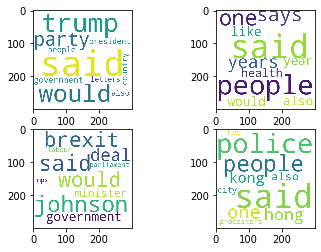

In [76]:
# 4. Topic visualization
# 4.a. Word cloud
# Display a word cloud for a topic. Display the top-10 words and use their term loadings as weight/frequency.

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, term_weights in enumerate(model_lda.components_):
    top_idxs = (-term_weights).argsort()[:10]
    top_words = [model_vect.get_feature_names()[idx] for idx in top_idxs]
    word_freqs = dict(zip(top_words, term_weights[top_idxs]))
    wc = WordCloud(background_color="white",width=300,height=300, max_words=10).generate_from_frequencies(word_freqs)
    plt.subplot(2, 2, i+1)
    plt.imshow(wc)